In [1]:
from ConvNet import *
from utils import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
%load_ext autoreload
%autoreload 2
!rm -r log_graph

In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9679323770577446023, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 118744984558253421
 physical_device_desc: "device: XLA_CPU device"]

## I. Basic operation with tensorFlow

In [3]:
tf.reset_default_graph()

#setup
x = tf.constant(1.,name="input_value")
w = tf.Variable(0.8, name="weight")
y = tf.multiply(w , x, name="output_value")
y_ = tf.constant(0.0)
loss = (y - y_)**2

#Print graph
# monitor_operation()

#Optimizer
train_step = tf.train.GradientDescentOptimizer(0.025).minimize(loss)

#Summary
tf.summary.scalar('ouput', y)
tf.summary.scalar("loss", loss)
merged_summary_op = tf.summary.merge_all()


with tf.Session() as sess:
    summary_writer = tf.summary.FileWriter('log_test-graph')
    summary_writer.add_graph(sess.graph)
    
    init = tf.global_variables_initializer()
    sess.run(init)
    for i in range(100):
        summary_str = sess.run(merged_summary_op)
        summary_writer.add_summary(summary_str, i)
        sess.run(train_step)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


**Acces to the tensorboard:**  
*python -m tensorboard.main --logdir=log_test-graph*  
then go to *http://localhost:6006*

## II. Dataset

/home/thaithai1/cloud/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


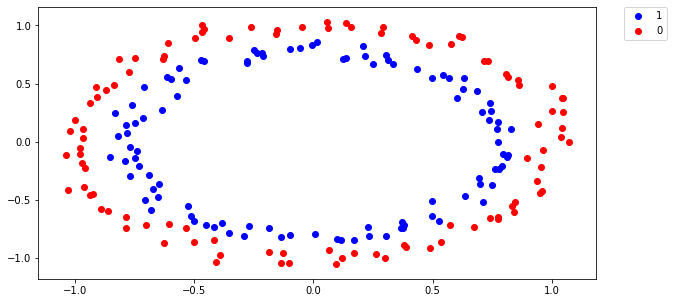

In [4]:
select='circle' # 'blob' or 'moon'
if select == 'moon':
    from sklearn.datasets import make_moons
    X_ori, y_ori = make_moons(n_samples=200, noise=0.1)
elif select == 'blob':
    from sklearn.datasets.samples_generator import make_blobs
    np.random.seed(1)
    X_ori, y_ori = make_blobs(n_samples=200, centers=2, n_features=2)
elif select == 'circle':
    from sklearn.datasets.samples_generator import make_circles
    X_ori, y_ori = make_circles(n_samples=200, noise=0.05)


plt.figure(figsize=(10,5))
plt.scatter(*zip(*X_ori[y_ori==1]), c= 'b', label = '1')
plt.scatter(*zip(*X_ori[y_ori==0]), c= 'r', label = '0')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [5]:
X = X_ori.T
idx=np.random.permutation(X.shape[1])
y=y_ori.reshape(-1,1).T
X_train, X_test = X[:,idx[:int(X.shape[1]*0.8)]], X[:,idx[int(X.shape[1]*0.8):]]
y_train, y_test = y[:,idx[:int(X.shape[1]*0.8)]], y[:,idx[int(X.shape[1]*0.8):]]

## II. Fully Connected Network

### a. Pick the model 

In [ ]:
lr_list = [1e-4, 1e-3, 1e-2, 1e-1, 1,10,100][::-1]
for i,lr in enumerate(lr_list):
    print('learning rate = %s' % lr)
    model=FC_binary_class(X_train, y_train, X_test, y_test)
    model.add_FC(20)
    model.add_FC(10)
    model.add_FC(10)
    model.compile()
    model.train(epoch = 3001 , batch_size = 32,lr = lr, optimizer = 'adam', filename = f'log_graph/lr={lr}')
    print('\n=================================\n')

learning rate = 100






epoch 0, training loss 9.55573, test loss 7.8287888, test accuracy 0.575
epoch 300, training loss 9.55573, test loss 7.8287888, test accuracy 0.575


By checking the learning curves in the tensorboard, we pick **learning rate = 1e-2**

### b. Train the model

In [ ]:
lr = 1e-2
model=FC_binary_class(X_train, y_train, X_test, y_test)
model.add_FC(20)
model.add_FC(10)
model.add_FC(10)
model.compile()
model.train(epoch = 2001 , batch_size = 32,lr = lr, optimizer = 'adam', filename = 'log_graph2')

## III Model vizualisation

In [ ]:
#grid
xx, yy = np.mgrid[np.min(X_ori[:,0]):np.max(X_ori[:,0]):.01, np.min(X_ori[:,1]):np.max(X_ori[:,1]):.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = model.predict_probs(grid.T).reshape(xx.shape)


f, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(xx, yy, probs,25, cmap='RdBu',vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])
ax.scatter(*zip(*X_ori), c= y_ori, s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)


ax.set(aspect="equal", xlim=(np.min(X_ori[:,0]),np.max(X_ori[:,0])), \
       ylim = (np.min(X_ori[:,1]),np.max(X_ori[:,1])) , xlabel="$X_1$", ylabel="$X_2$")
plt.show()